# Pantograph Mechanism Kinematics and PRBM Study

This study focuses on analyzing the kinematics of a pantograph mechanism and conducting a PRBM study to investigate the design parameters of compliant joints.

## Pantograph Mechanism
A pantograph mechanism is a mechanical linkage of rigid bars connected by hinged joints. It maintains a consistent geometric relationship between two sets of parallel bars while allowing relative motion.

## Transmission Ratio
We will explore the transmission ratio between two linear movements within the pantograph mechanism. The transmission ratio represents the ratio of displacement or velocity between the input and output motions.

## PRBM Study
A PRBM study will be conducted to understand the design parameters of compliant joints. PRBM is a numerical modeling technique that parameterizes geometry and material properties to analyze the behavior of compliant structures efficiently and accurately.

By investigating the kinematics of the pantograph mechanism and the effects of design parameters on the transmission ratio, we aim to optimize its performance in various engineering applications.


In [3]:
from matplotlib.animation import FuncAnimation
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from IPython.display import HTML

In [4]:
# Variable definititon

l_ol1, l_ol2, l_or1, l_or2, l_il, l_ir = sm.symbols('l_ol1, l_ol2, l_or1, l_or2, l_il, l_ir')

a, q1, q2 = sm.symbols('a, q1, q2')

N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')

O, P1, P2, P3, P4, P5 = sm.symbols('O, P1, P2, P3, P4, P5', cls = me.Point)

A.orient_axis(N, N.z, q1)
B.orient_axis(A, A.z, q2)

In [5]:
# Kinematic loop 

loop1 = l_ir * A.x + l_or1 * B.x - a * N.x

P1.set_pos(P2, l_or1 * B.x)
P2.set_pos(O, l_ir * A.x)
P3.set_pos(P2, - l_or2 * B.x)
P4.set_pos(P3, - l_ol2 * A.x)
P5.set_pos(P4, - l_ol1 * A.x)

fh1 = loop1.dot(N.x).simplify()
fh2 = loop1.dot(N.y).simplify()
fh3 = P5.pos_from(P3).dot(N.y) + P3.pos_from(P1).dot(N.y)

transmission = -P5.pos_from(O).dot(N.x) / P1.pos_from(O).dot(N.x)
pant_repl = {l_ol2: l_ir}
transmission = transmission.xreplace(pant_repl)
transmission = sm.trigsimp(transmission)

fh_expr = sm.Matrix([fh1, fh2, fh3])
fh_expr = fh_expr.xreplace(pant_repl)

fh_expr

Matrix([
[                                        -a + l_ir*cos(q1) + l_or1*cos(q1 + q2)],
[                                             l_ir*sin(q1) + l_or1*sin(q1 + q2)],
[(-l_ir - l_ol1)*sin(q1) + (-l_or1 - l_or2)*(sin(q1)*cos(q2) + sin(q2)*cos(q1))]])

In [6]:
# ### Find solution ###

# Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
p_vals = [0.350, 0.35, 0.140, 0.562 ] #+ 1*0.126
p = [l_ir, l_or1, l_or2, a]

subs1 = {k: v for k, v in zip(p, p_vals)}
fh = fh_expr.subs(subs1)

# Lambdify
q = [q1, q2, l_ol1] 
x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
eval_fh = sm.lambdify((q, ), fh)

def sys(x):   
    # Define the equations
    fh1_val = eval_fh(x)[0, 0]
    fh2_val = eval_fh(x)[1, 0]
    fh3_val = eval_fh(x)[2, 0]
    
    # Return the equations as a list
    return [fh1_val, fh2_val, fh3_val]

# Solve the system of equations
solution = fsolve(sys, x0)

# Extract the solutions for each variable
y1_solution, y2_solution = solution[0], solution[1]
sol = np.array([y1_solution, y2_solution, solution[2]])

sol

array([0.63872397, 5.00573736, 0.14      ])

Transmission:  0.3999999999957449


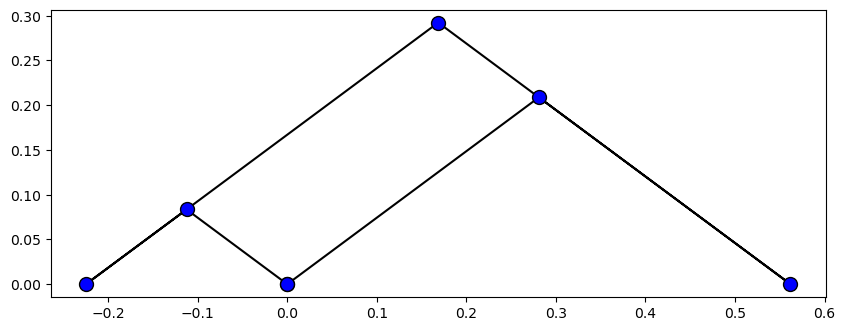

In [7]:
# Visualization

coordinates = O.pos_from(O).to_matrix(N)

for point in [P2, P1, P3, P5, P4, O]:
    coordinates = coordinates.row_join(point.pos_from(O).xreplace(pant_repl).to_matrix(N))

coordinates
eval_point_coords = sm.lambdify((q, p), coordinates, cse=True)
eval_transmission = sm.lambdify((q, p), transmission, cse=True)

x, y, z = eval_point_coords(sol, p_vals)

fig, ax = plt.subplots()
fig.set_size_inches((10.0, 10.0))
ax.set_aspect('equal')

lines, = ax.plot(x, y, color='black',
                 marker='o', markerfacecolor='blue', markersize=10)

print('Transmission: ', eval_transmission(sol, p_vals))


# PRBM - schematic view of mechanism:

![OpenAI Logo](images/prbm.png)

In [8]:
# #### Iteration for angle range ####
sol_rec = []

# Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
for i in np.arange(0.3 , 0.3 + 1*0.126, 0.01):
    p_vals = [0.35, 0.35, 0.140, i]
    p = [l_ir, l_or1, l_or2, a]

    subs1 = {k: v for k, v in zip(p, p_vals)}
    fh = fh_expr.subs(subs1)

    # Lambdify
    q = [q1, q2, l_ol1] 
    x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
    eval_fh = sm.lambdify((q, ), fh)

    def sys(x):   
        # Define the equations
        fh1_val = eval_fh(x)[0, 0]
        fh2_val = eval_fh(x)[1, 0]
        fh3_val = eval_fh(x)[2, 0]

        # Return the equations as a list
        return [fh1_val, fh2_val, fh3_val]

    # Solve the system of equations
    solution = fsolve(sys, x0)

    # Extract the solutions for each variable
    y1_solution, y2_solution = solution[0], solution[1]
    sol = np.array([y1_solution, y2_solution, solution[2]])
    
    sol_rec.append(sol)
#sol_rec

In [9]:
# ### PRBM ###

# Definition of symbols to derivate expressions
x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
x_vec = [x1, x2]

omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
t = me.dynamicsymbols._t

k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
k = [k1, k2, k3, k4, k5, k6, k7]

phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
phis = [phi1, phi2, phi3, phi4, phi5]

# For the PRBM the angles at all the joint between starting and deformed position are needed
q3 = q2 - np.pi
q4 = np.pi - q1 - q3
q5 = np.pi - q3 

q_expr = sm.Matrix([q1, q2, q3, q4, q5])
sm.init_printing()

# New dynamic variable to perform time derivatives
dyn_repl = {q1:x1, q2:x2, a:xl}
om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}

fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                 fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

# Angular speeds as function of linear speed                 
sol = sm.solve(fhd, (omega1, omega2))

# To find the ectuation force, the virtual work principle has to be used --->
# ---> virtual displacement have to be found d_ang/d_a
virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

# Symbolic force expression1
Fl = k1 * phi1 * virtual_disp[0]+ \
    k2 * phi3 * virtual_disp[2]+ \
    k3 * phi4 * virtual_disp[3]+ \
    k4 * phi1 * virtual_disp[0]+ \
    k5 * phi3 * virtual_disp[2]+ \
    k6 * phi3 * virtual_disp[2]+ \
    k7 * phi4 * virtual_disp[3]
    
Fl = sm.trigsimp(Fl.xreplace(sol))


# Angles evaluation 
eval_q = sm.lambdify((q[:2],), q_expr)
phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
x_vals = sol_rec[-1][:2]
k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals), phi_vals


(array([34.1914883]),
 array([[-11.49296412],
        [ 22.98592824],
        [ 22.98592824],
        [-11.49296412],
        [-22.98592824]]))

![OpenAI Logo](images/joints.png)

In [10]:

# ### Definition of different types of compliant joints ### 

E = 210e9 # Young modulus dependent on material

# Rectangular joint
t_r, b_r, L_r = [2e-3,5e-2,0.1]
I_r = (1/12) * b_r * (t_r**3);
K_r = (E*I_r)/L_r

# Cartwheel joint
t_cw, b_cw, L_cw = [0,0,1]
I_cw = (1/12) * b_cw * (t_cw**3);
K_cw = 8*((E * I_cw) / L_cw)

# Cross flexure joint 
t_cf, b_cf, L_cf = [1e-3,15e-3,44e-3]
I_cf = (1/12)*(b_cf/2)*(t_cf**3);
K_cf = 2*(E*I_cf)/L_cf

K_cf

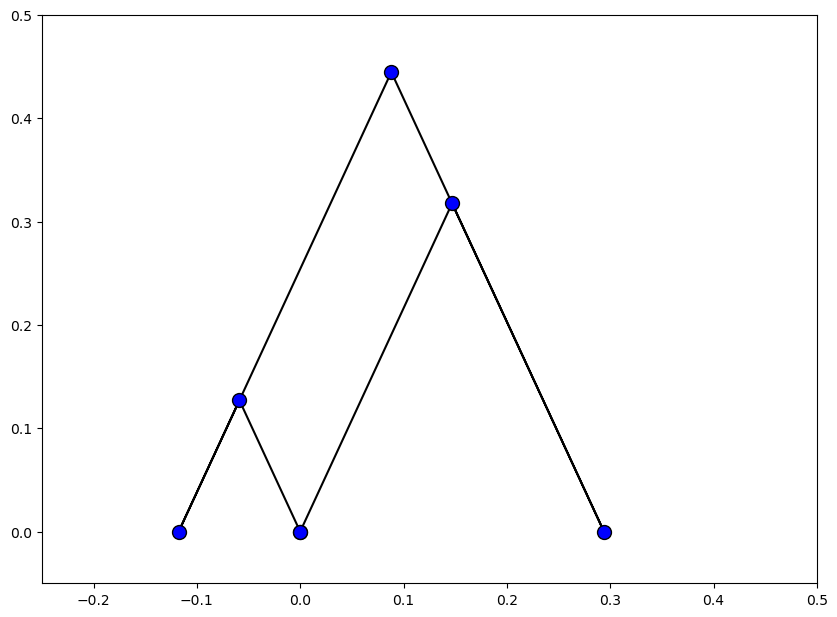

In [11]:
# #### Iteration for animation ####
sol_rec = []

# Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
for i in np.arange(0.3 - 0.126, 0.3 , 0.01):
    p_vals = [0.350, 0.35, 0.140, i]
    p = [l_ir, l_or1, l_or2, a]

    subs1 = {k: v for k, v in zip(p, p_vals)}
    fh = fh_expr.subs(subs1)

    # Lambdify
    q = [q1, q2, l_ol1] 
    x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
    eval_fh = sm.lambdify((q, ), fh)

    def sys(x):   
        # Define the equations
        fh1_val = eval_fh(x)[0, 0]
        fh2_val = eval_fh(x)[1, 0]
        fh3_val = eval_fh(x)[2, 0]

        # Return the equations as a list
        return [fh1_val, fh2_val, fh3_val]

    # Solve the system of equations
    solution = fsolve(sys, x0)

    # Extract the solutions for each variable
    y1_solution, y2_solution = solution[0], solution[1]
    sol = np.array([y1_solution, y2_solution, solution[2]])
    
    sol_rec.append(sol)
sol_rec

# Animation

fig, ax = plt.subplots()
lines, = ax.plot([], [], color='black',
                 marker='o', markerfacecolor='blue', markersize=10)

fig.set_size_inches((10.0, 10.0))
ax.set_aspect('equal')
ax.set_xlim(-0.25, 0.5)
ax.set_ylim(-0.05, 0.5)

coordinates = O.pos_from(O).to_matrix(N)

for point in [P2, P1, P3, P5, P4, O]:
    coordinates = coordinates.row_join(point.pos_from(O).xreplace(pant_repl).to_matrix(N))

eval_point_coords = sm.lambdify((q, p), coordinates, cse=True)
eval_transmission = sm.lambdify((q, p), transmission, cse=True)



def update(frame):
    x, y, z = eval_point_coords(sol_rec[frame], p_vals)
    lines.set_data(x, y)
    return lines,

# Set the desired FPS (e.g., 10 frames per second)
fps = 10
# Calculate the interval based on the desired FPS
interval = 1000 / fps

# Create the animation
animation = FuncAnimation(fig, update, frames=13, blit=True, interval=interval)
HTML(animation.to_jshtml())


In [71]:
# The goal of this cell is to plot the force needed for the actuation in the decided range of motion

force_rec = []

for j in np.arange(0, 0.126, 0.01):

    sol_rec = []

    # Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
    for i in np.array([0.3 , 0.3 + j]):
        p_vals = [0.35, 0.35, 0.140, i]
        p = [l_ir, l_or1, l_or2, a]

        subs1 = {k: v for k, v in zip(p, p_vals)}
        fh = fh_expr.subs(subs1)

        # Lambdify
        q = [q1, q2, l_ol1] 
        x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
        eval_fh = sm.lambdify((q, ), fh)

        def sys(x):   
            # Define the equations
            fh1_val = eval_fh(x)[0, 0]
            fh2_val = eval_fh(x)[1, 0]
            fh3_val = eval_fh(x)[2, 0]

            # Return the equations as a list
            return [fh1_val, fh2_val, fh3_val]

        # Solve the system of equations
        solution = fsolve(sys, x0)

        # Extract the solutions for each variable
        y1_solution, y2_solution = solution[0], solution[1]
        sol = np.array([y1_solution, y2_solution, solution[2]])

        sol_rec.append(sol)

    
    # ### PRBM ###

    # Definition of symbols to derivate expressions
    x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
    x_vec = [x1, x2]

    omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
    t = me.dynamicsymbols._t

    k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
    k = [k1, k2, k3, k4, k5, k6, k7]

    phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
    phis = [phi1, phi2, phi3, phi4, phi5]

    # For the PRBM the angles at all the joint between starting and deformed position are needed
    q3 = q2 - np.pi
    q4 = np.pi - q1 - q3
    q5 = np.pi - q3 

    q_expr = sm.Matrix([q1, q2, q3, q4, q5])
    sm.init_printing()

    # New dynamic variable to perform time derivatives
    dyn_repl = {q1:x1, q2:x2, a:xl}
    om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}

    fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                     fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

    # Angular speeds as function of linear speed                 
    sol = sm.solve(fhd, (omega1, omega2))

    # To find the ectuation force, the virtual work principle has to be used --->
    # ---> virtual displacement have to be found d_ang/d_a
    virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
    eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

    # Symbolic force expression1
    Fl = k1 * phi1 * virtual_disp[0]+ \
        k2 * phi3 * virtual_disp[2]+ \
        k3 * phi4 * virtual_disp[3]+ \
        k4 * phi1 * virtual_disp[0]+ \
        k5 * phi3 * virtual_disp[2]+ \
        k6 * phi3 * virtual_disp[2]+ \
        k7 * phi4 * virtual_disp[3]

    Fl = sm.trigsimp(Fl.xreplace(sol))


    # Angles evaluation 
    eval_q = sm.lambdify((q[:2],), q_expr)
    phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
    x_vals = sol_rec[-1][:2]
    k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

    eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
    force_rec.append(eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals))
    sol_rec = []


# Negative displacement
force_rec_neg = []

for j in np.arange(-0.126, 0, 0.01):

    sol_rec = []

    # Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
    for i in np.array([0.3, 0.3 + j]):
        p_vals = [0.35, 0.35, 0.140, i]
        p = [l_ir, l_or1, l_or2, a]

        subs1 = {k: v for k, v in zip(p, p_vals)}
        fh = fh_expr.subs(subs1)

        # Lambdify
        q = [q1, q2, l_ol1] 
        x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
        eval_fh = sm.lambdify((q, ), fh)

        def sys(x):   
            # Define the equations
            fh1_val = eval_fh(x)[0, 0]
            fh2_val = eval_fh(x)[1, 0]
            fh3_val = eval_fh(x)[2, 0]

            # Return the equations as a list
            return [fh1_val, fh2_val, fh3_val]

        # Solve the system of equations
        solution = fsolve(sys, x0)

        # Extract the solutions for each variable
        y1_solution, y2_solution = solution[0], solution[1]
        sol = np.array([y1_solution, y2_solution, solution[2]])

        sol_rec.append(sol)

    
    # ### PRBM ###

    # Definition of symbols to derivate expressions
    x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
    x_vec = [x1, x2]

    omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
    t = me.dynamicsymbols._t

    k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
    k = [k1, k2, k3, k4, k5, k6, k7]

    phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
    phis = [phi1, phi2, phi3, phi4, phi5]

    # For the PRBM the angles at all the joint between starting and deformed position are needed
    q3 = q2 - np.pi
    q4 = np.pi - q1 - q3
    q5 = np.pi - q3 

    q_expr = sm.Matrix([q1, q2, q3, q4, q5])
    sm.init_printing()

    # New dynamic variable to perform time derivatives
    dyn_repl = {q1:x1, q2:x2, a:xl}
    om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}

    fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                     fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

    # Angular speeds as function of linear speed                 
    sol = sm.solve(fhd, (omega1, omega2))

    # To find the ectuation force, the virtual work principle has to be used --->
    # ---> virtual displacement have to be found d_ang/d_a
    virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
    eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

    # Symbolic force expression1
    Fl = k1 * phi1 * virtual_disp[0]+ \
        k2 * phi3 * virtual_disp[2]+ \
        k3 * phi4 * virtual_disp[3]+ \
        k4 * phi1 * virtual_disp[0]+ \
        k5 * phi3 * virtual_disp[2]+ \
        k6 * phi3 * virtual_disp[2]+ \
        k7 * phi4 * virtual_disp[3]

    Fl = sm.trigsimp(Fl.xreplace(sol))


    # Angles evaluation 
    eval_q = sm.lambdify((q[:2],), q_expr)
    phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
    x_vals = sol_rec[-1][:2]
    k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

    eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
    force_rec_neg.append(eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals))
    sol_rec = []





In [72]:
force = force_rec_neg
force = np.abs(force).T
force = np.array([force,np.array(force_rec).T ]).flatten()
#np.hstack((force[0],force_rec[0].T))

<function matplotlib.pyplot.show(close=None, block=None)>

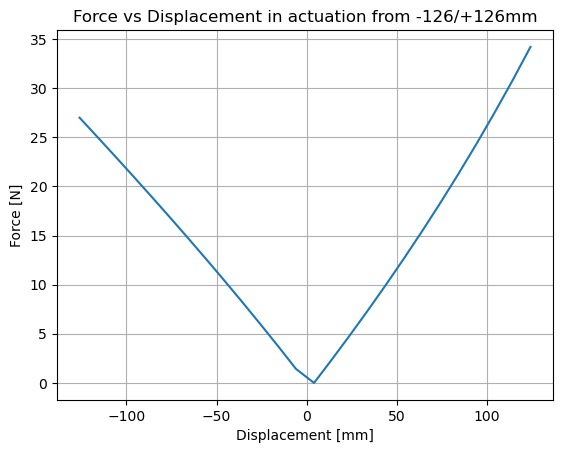

In [73]:

force_rec_neg.append(force_rec)

fig, ax = plt.subplots()
ax.plot(np.arange(-126, 126, 10), force)

plt.title('Force vs Displacement in actuation from -126/+126mm')
plt.xlabel('Displacement [mm]')
plt.ylabel('Force [N]')

# Set equal scale
#ax.set_xscale('log')
#ax.set_yscale('log')

plt.grid()
plt.show